# Pet Classification Challenge - Part 2/2
## Transfer Learning with Pretrained Models

## Feature Extraction Using a Pretrained Model

In this exercise, I take a model trained on a large dataset and apply it to the smaller dataset in focus: ""https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset/data""

The purpose is to extract the intermediate representations (features) produced by the model. These representations can be highly informative for this computer vision task, even if the task is quite different from the one the original model was trained on. Thus shows the adaptability of convolutional neural networks (convnets).

The pretrained model is the  [Inception V3 model](https://arxiv.org/abs/1512.00567), pre-trained on [ImageNet](http://image-net.org/), a large dataset of web images (1.4M images and 1000 classes).

The first step is to choose which intermediate layer of Inception V3 to use for feature extraction. A common approach is to use the output from the last layer before the Flatten operation, known as the "bottleneck layer." The rationale behind this is that the subsequent fully connected layers are highly specialized for the original task the network was trained on, and as a result, the features learned by these layers may not be very useful for a new task. In contrast, the bottleneck features tend to retain more general characteristics.

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model


Let's download an Inception V3 model preloaded with weights trained on ImageNet:

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-03-11 12:48:16--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  78.9MB/s    in 1.1s    

2025-03-11 12:48:18 (78.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)


By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction.

In [4]:
for layer in pre_trained_model.layers:
  layer.trainable = False

Let's make the model non-trainable, since it's needed just for feature extraction. It means don't update the weights of the pretrained model during training.

Let's deep dive the item layers available in the model

In [5]:
for layer in sorted(pre_trained_model.layers, key=lambda x: x.name):
    print(layer.name)



activation
activation_1
activation_10
activation_11
activation_12
activation_13
activation_14
activation_15
activation_16
activation_17
activation_18
activation_19
activation_2
activation_20
activation_21
activation_22
activation_23
activation_24
activation_25
activation_26
activation_27
activation_28
activation_29
activation_3
activation_30
activation_31
activation_32
activation_33
activation_34
activation_35
activation_36
activation_37
activation_38
activation_39
activation_4
activation_40
activation_41
activation_42
activation_43
activation_44
activation_45
activation_46
activation_47
activation_48
activation_49
activation_5
activation_50
activation_51
activation_52
activation_53
activation_54
activation_55
activation_56
activation_57
activation_58
activation_59
activation_6
activation_60
activation_61
activation_62
activation_63
activation_64
activation_65
activation_66
activation_67
activation_68
activation_69
activation_7
activation_70
activation_71
activation_72
activation_73
ac

The layer we will use for feature extraction in Inception v3 is called mixed7. While it is not the network's bottleneck, we choose it to maintain a sufficiently large feature map (7x7 in this case). Using the bottleneck layer would result in a smaller 3x3 feature map, which is a bit too small. Let's extract the output from mixed7:

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output.shape)
last_output = last_layer.output


last layer output shape: (None, 7, 7, 768)


In summary, the output choosen of a neural network layer represents the features extracted from the input data. For the mixed7 layer in Inception v3, the output shape is `(None, 7, 7, 768)`. The `None` refers to the batch size, which can be any number. The `7x7` indicates the spatial dimensions (height and width) of the feature map, and `768` represents the number of channels (or features) in the output. This output contains the learned features up to the mixed7 layer, which can be used for further tasks like feature extraction for other applications.

Model configuration following a fully connected classifier on top of `last_output`:

In [7]:
from tensorflow.keras.optimizers import Adam

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(37, activation='softmax')(x) # 37 is the number of breeds

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])


It's a multiclass problem wich requires to handle a scenario where there are multiple possible classes, giving probabilities that sum to 1 (softmax).

## Leveraging Pretrained Models from PyTorch

In [8]:
import torch
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load train+validation and test sets
trainval_dataset = datasets.OxfordIIITPet(root="./data", split="trainval", transform=transform, download=True)
test_dataset = datasets.OxfordIIITPet(root="./data", split="test", transform=transform, download=True)

# Print dataset sizes
print(f"Total Train+Validation size: {len(trainval_dataset)}")  # Should be 3,680
print(f"Total Test size: {len(test_dataset)}")  # Should be 3,669

100%|██████████| 792M/792M [00:34<00:00, 22.7MB/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:01<00:00, 11.3MB/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet
Total Train+Validation size: 3680
Total Test size: 3669


In [9]:
import os

# Specify the root directory (can be /content/pet_dataset/)
root_dir = '/content/data/oxford-iiit-pet/images'

# Use os.walk to explore the directory structure
for root, dirs, files in os.walk(root_dir):
    # Show the full path of the directory
    print(f"Directory: {root}")
    # Show subdirectories
    print(f"Subdirectories: {dirs}")
    # Show files in that directory
    print(f"Files: {files}")
    # Show the total number of files in the current directory
    print(f"Total Number of files in {root}: {len(files)}")
    print("="*50)  # Separator for clarity

# If you want the total number of files in the entire root directory (including all subdirectories)
total_files = sum([len(files) for _, _, files in os.walk(root_dir)])
print(f"Total Number of files in {root_dir}: {total_files}")

Directory: /content/data/oxford-iiit-pet/images
Subdirectories: []
Files: ['great_pyrenees_194.jpg', 'pug_117.jpg', 'miniature_pinscher_151.jpg', 'yorkshire_terrier_74.jpg', 'pomeranian_166.jpg', 'Bombay_99.jpg', 'english_setter_15.jpg', 'keeshond_199.jpg', 'samoyed_36.jpg', 'samoyed_128.jpg', 'Ragdoll_116.jpg', 'english_setter_90.jpg', 'newfoundland_13.jpg', 'leonberger_54.jpg', 'american_pit_bull_terrier_47.jpg', 'chihuahua_148.jpg', 'beagle_7.jpg', 'basset_hound_64.jpg', 'Birman_86.jpg', 'leonberger_182.jpg', 'scottish_terrier_7.jpg', 'Persian_104.jpg', 'Siamese_9.jpg', 'Ragdoll_199.jpg', 'american_bulldog_21.jpg', 'Birman_77.jpg', 'Sphynx_179.jpg', 'samoyed_130.jpg', 'havanese_75.jpg', 'great_pyrenees_170.jpg', 'chihuahua_183.jpg', 'newfoundland_121.jpg', 'chihuahua_100.jpg', 'english_setter_167.jpg', 'miniature_pinscher_101.jpg', 'scottish_terrier_148.jpg', 'wheaten_terrier_24.jpg', 'Bengal_100.jpg', 'saint_bernard_108.jpg', 'saint_bernard_154.jpg', 'scottish_terrier_50.jpg', 'Bri

In [13]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Image directory
IMG_DIR = "./data/oxford-iiit-pet/images/"

# Read trainval and test file lists
trainval_file = "./data/oxford-iiit-pet/annotations/trainval.txt"
test_file = "./data/oxford-iiit-pet/annotations/test.txt"

# Create dataframes for trainval and test
trainval_df = pd.read_csv(trainval_file, delim_whitespace=True, header=None, names=["filename", "class", "species", "breed_id"])
test_df = pd.read_csv(test_file, delim_whitespace=True, header=None, names=["filename", "class", "species", "breed_id"])

# Convert 'class' column to string
trainval_df["class"] = trainval_df["class"].astype(str)
test_df["class"] = test_df["class"].astype(str)

# Append image extension
trainval_df["filename"] = trainval_df["filename"] + ".jpg"
test_df["filename"] = test_df["filename"] + ".jpg"

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Data generators (train, validation, test)
train_generator = train_datagen.flow_from_dataframe(
    trainval_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2).flow_from_dataframe(
    trainval_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Load pre-trained InceptionV3 model
pre_trained_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Unfreeze only layers after "mixed6"
unfreeze = False
for layer in pre_trained_model.layers:
    if unfreeze:
        layer.trainable = True
    if layer.name == 'mixed6':
        unfreeze = True

# Add classification layers
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.7)(x)
x = layers.Dense(37, activation='softmax')(x)


model = Model(pre_trained_model.input, x)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['categorical_accuracy']
)


# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stops training if no improvement for 5 epochs
    restore_best_weights=True,
    verbose=2
)



Found 2944 validated image filenames belonging to 37 classes.
Found 736 validated image filenames belonging to 37 classes.
Found 3669 validated image filenames belonging to 37 classes.


<ipython-input-13-c7db9d58ff73>:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  trainval_df = pd.read_csv(trainval_file, delim_whitespace=True, header=None, names=["filename", "class", "species", "breed_id"])
<ipython-input-13-c7db9d58ff73>:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df = pd.read_csv(test_file, delim_whitespace=True, header=None, names=["filename", "class", "species", "breed_id"])


In [14]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Numero totale di batch nel set di addestramento
    epochs=50,  # Increased max epochs, but early stopping will prevent overfitting
    validation_data=validation_generator,
    validation_steps=len(validation_generator),  # Numero totale di batch nel set di validazione
    verbose=1,
    callbacks=[reduce_lr, early_stopping]
)


# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print(f"Test Accuracy: {test_acc:.2f}")



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 116s 569ms/step - categorical_accuracy: 0.2601 - loss: 349.1087 - val_categorical_accuracy: 0.4620 - val_loss: 176.7010 - learning_rate: 1.0000e-04
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 101s 507ms/step - categorical_accuracy: 0.7110 - loss: 148.6292 - val_categorical_accuracy: 0.5761 - val_loss: 86.3551 - learning_rate: 1.0000e-04
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 504ms/step - categorical_accuracy: 0.8085 - loss: 72.9403 - val_categorical_accuracy: 0.5217 - val_loss: 45.6657 - learning_rate: 1.0000e-04
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 509ms/step - categorical_accuracy: 0.8342 - loss: 39.1352 - val_categorical_accuracy: 0.5516 - val_loss: 28.6674 - learning_rate: 1.0000e-04
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 502ms/step - categorical_accuracy: 0.8564 - loss: 24.8692 - val_categorical_accuracy: 0.5530 - val_loss: 21.8831 - learning_rate: 1.0000e-04
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 501ms/step - categorical_accuracy: 0.8

<Figure size 640x480 with 0 Axes>

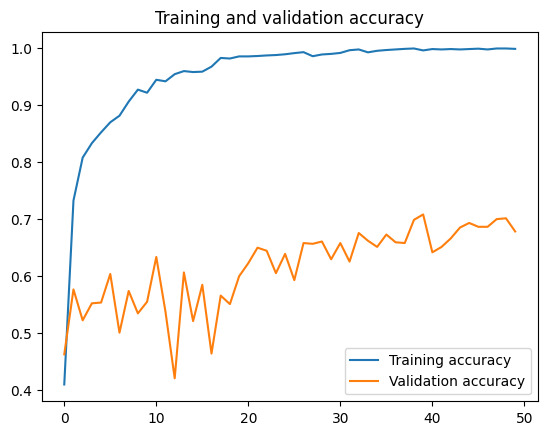

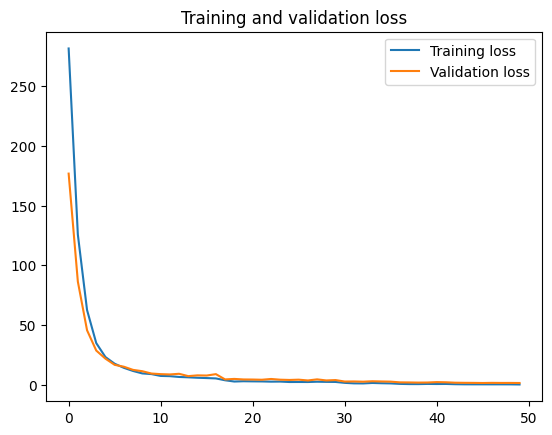

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()